118


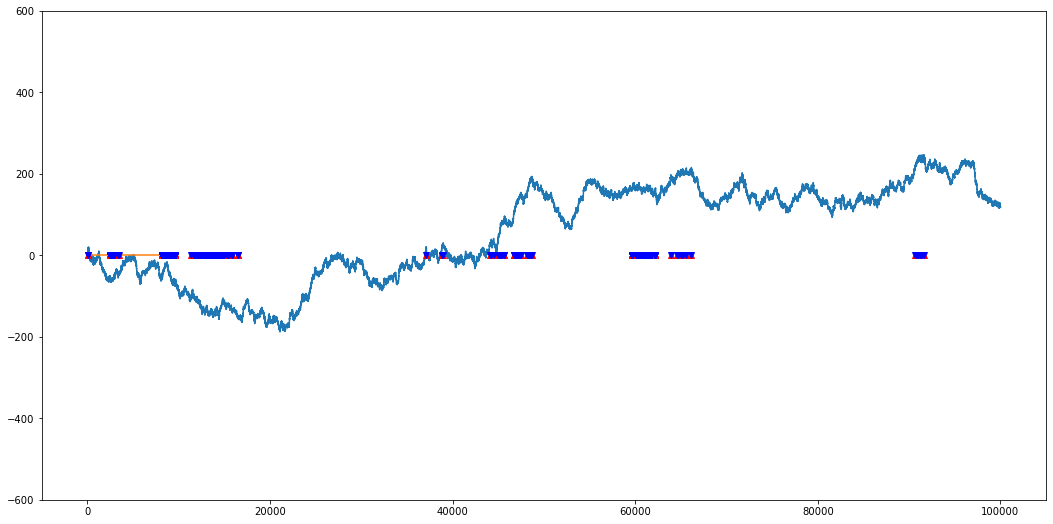

In [5]:
from matplotlib import pyplot as plt
import random 
import numpy as np
from collections import Counter
import sys

n = 100000
res = []
mes = []
yous = []
ntoj = {"0": "グー", "1": "チョキ", "2": "パー"}
match = 0

rr = [0]


def get_res(hand1, hand2):
    return (hand1 - hand2) % 3

def get_counter(arr):
    return list(map(lambda x: (str(x[0]).translate(str.maketrans(ntoj)), x[1]/cnt), Counter(arr).items()))

# じゃんけんbotのベースクラス
# 対戦相手はこっち
class jankenman():
    def __init__(self):
        self.hands = []
        self.janken_ratio = {0: 0, 1: 0, 2: 0}
        self.point = 0
        self.match = 0

    # インスタンス名で呼ぶ度に実行される。じゃんけん。
    def __call__(self):
        hand = self.get_jan()
        self.hands.append(hand)
        self.janken_ratio[hand] += 1
        return hand

    # 敵はランダム
    def get_jan(self):
        return random.randint(0,2)

    # 相手の出した手の出現率を知るために相手のインスタンスを持つ。
    def set_oppo(self, oppo):
        self.oppo = oppo

# バイアスモード搭載クラス
# 自分はこっち
class jankenMe(jankenman):
    def __init__(self):
        super().__init__()
        self.streak = 0
        # 休眠時間
        self.sleep = False
        self.sleepCount = 0
        self.biasmode = False
        self.th = 10
        self.streakThresh = n
        self.pointThresh = 0
        self.sleepThresh = 50
        self.startBias = []
        self.endBias = []
        self.confThresh = 2.58

    def __call__(self):
        self.match += 1
        self.change_mode()
        self.get_confidence()
        
        return super().__call__()

    def get_jan(self):
        # 基準値を「現在の基準値と保有ポイントの平均」と、「保有ポイント」のどちらか高い方にする。
        self.pointThresh = max((self.point + self.pointThresh)/2, self.pointThresh)
        if self.biasmode:
            self.streak += 1
            # バイアスモード時は出現率が最も少ない手に勝つ手を出し続ける。
            hand = min(self.oppo.janken_ratio, key=self.oppo.janken_ratio.get)
            return (hand + 2) % 3
        
        else:
            self.sleepCount += 1
            if self.sleepCount >= self.sleepThresh:
                self.sleep = False
            return random.randint(0,2)

    def get_confidence(self):
        # 下限は切り上げ
        llim = -1 * ((((1/3)-self.confThresh*(2/(self.match*9))**0.5)*-self.match) // 1)
        # 上限は切り捨て
        ulim = ((1/3)+self.confThresh*(2/(self.match*9))**0.5)*self.match // 1
        # 敵が99%信頼区間外の偏りがある場合、バイアスモードを強制起動する。
        # print("Not Random!!", self.match)
        return any([i < llim or ulim < i for i in self.oppo.janken_ratio.values()])
        

# バイアスモードの切替
    def change_mode(self):
        # バイアスモードに入る条件
        # バイアスモードでない and スリープ中でない and ポイントが(基準値 or 初期閾値)より大きい
        if not self.biasmode and ((not self.sleep and self.point > max(self.th, self.pointThresh)) or self.get_confidence()):
            self.biasmode = True
            if len(self.startBias) == len(self.endBias):
                self.startBias.append(self.match)
                
        # バイアスモードが解除される条件
        # バイアスモードの時 and (バイアスモードに入ってから経過した試合数が閾値以上 or ポイントが基準値を以下)
        elif self.biasmode and (self.streak >= self.streakThresh or self.point <= self.pointThresh):
            self.biasmode = False
            self.sleep = True
            self.sleepCount = 0
            self.streak = 0
            self.endBias.append(self.match)

    

# インスタンス生成
me = jankenMe()
you = jankenman()
# 敵インスタンスのセット
me.set_oppo(you)
you.set_oppo(me)
# じゃんけん
for i in range(1, n+1):
    r = get_res(you(), me())
    r = r if r != 2 else -1
    res.append(r)
    rr.append(rr[i-1]+r)
    me.point += r

print(me.point)
# グラフづくり
fig = plt.figure(figsize=(18.0, 9.0))
plt.plot(range(n+1), rr)
plt.plot(range(0, 10000, 300), [0 for _ in range(0, 10000,300)])
plt.plot(me.startBias, [0 for _ in range(len(me.startBias))], 'r^')
plt.plot(me.endBias, [0 for _ in range(len(me.endBias))], 'bv')
plt.ylim(-600, 600)
plt.show()